# Unsupervised Clustering 

### Add the src folder to the path

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [2]:
%load_ext autoreload
%autoreload 2

## Common imports

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy
from tissue_purifier.plot_utils.plot_results import plot_all_maps, plot_embeddings
from tissue_purifier.evaluation_utils.embeddings import get_z_score, get_pca, get_umap
from torch.nn import functional as F

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Read prediction from file

In [9]:
prediction_file = 'prediction_dict_loader0_TIS_728.pt'

predictions = torch.load(prediction_file)

for k,v in predictions.items():
    if isinstance(v, torch.Tensor):
        print(k, type(v), v.shape)
    elif isinstance(v, list):
        print(k, type(v), len(v))
    else:
        print(k, type(v))

metadata <class 'list'> 2400
features_student_bbone <class 'torch.Tensor'> torch.Size([2400, 32])
features_teacher_bbone <class 'torch.Tensor'> torch.Size([2400, 32])
features_student_head <class 'torch.Tensor'> torch.Size([2400, 32])
features_teacher_head <class 'torch.Tensor'> torch.Size([2400, 32])
classify_tissue_label <class 'torch.Tensor'> torch.Size([2400])
classify_healthy_sick <class 'torch.Tensor'> torch.Size([2400])
regress_moran <class 'torch.Tensor'> torch.Size([2400])
regress_loc_x <class 'torch.Tensor'> torch.Size([2400])


In [10]:
f_names = [metadata.f_name for metadata in predictions['metadata']]
morans = [metadata.moran for metadata in predictions['metadata']]

### UMAP and CLUSTERING

In [53]:
import igraph as ig
import leidenalg
import umap 
from sklearn.neighbors import kneighbors_graph
import scipy

f_names.append(f_names[-1])
morans.append(morans[-1])
tmp = torch.cat((predictions['features_student_bbone'], predictions['features_student_bbone'][-1:]), dim=0)

features = get_pca(tmp, n_components=50, z_score=True)
embeddings_pca = get_pca(tmp, n_components=2, z_score=True)

UMAP = umap.UMAP(
     spread=2.0,
     n_components=2,
     n_neighbors=15,
     metric="euclidean",
     random_state=0)
embeddings_umap = UMAP.fit_transform(features)
umap_graph = UMAP.graph_  # this is a symmetric matrix

def make_graph(umap_graph, normalized: bool = False):
    g = ig.Graph(directed=False)
    g.add_vertices(umap_graph.shape[0])  # each observation is a node
    row_index, col_index = umap_graph.nonzero()
    if normalized:
        degree = umap_graph.sum(axis=-1).getA().flatten()
        degree_sqrt = numpy.sqrt(degree)
        weights = umap_graph.data / (degree_sqrt[row_index] * degree_sqrt[col_index])
    else:
        weights = umap_graph.data
    edges = list(zip(row_index, col_index))
    g.add_edges(edges)
    g.es['weight'] = weights
    return g

def find_partition(g, partition_type, resolution_parameter):
    partition_kwargs = dict(resolution_parameter=resolution_parameter)
    part = leidenalg.find_partition(g, partition_type, n_iterations=-1, **partition_kwargs)
    cluster_labels = numpy.array(part.membership)
    return cluster_labels

def make_graph_merhtash(features, n_neighbors):
    # build the k-NN connecitivity graph
    a_nn = kneighbors_graph(
        features,
        n_neighbors,
        mode='connectivity',
        include_self=False)

    # calculate similarity weights
    sources_e, targets_e = a_nn.nonzero()
    dist_mat_e = numpy.linalg.norm(features[sources_e] - features[targets_e], axis=-1)
    weights_e = 1. - dist_mat_e / numpy.max(dist_mat_e)
    
    # make graph
    w_nn = scipy.sparse.coo_matrix((weights_e, (sources_e, targets_e)), shape=a_nn.shape)
    degree_n = numpy.asarray(w_nn.sum(-1)).flatten()
    normed_weights_e = weights_e / numpy.sqrt(degree_n[sources_e] * degree_n[targets_e])

    # build a graph object
    g = ig.Graph(directed=False)
    g.add_vertices(a_nn.shape[0])  # each observation is a node
    edges = list(zip(sources_e, targets_e))
    g.add_edges(edges)
    g.es['weight'] = normed_weights_e
    return g

def similarity_graph_to_distance_graph(sim_graph):
    sources, targets = sim_graph.nonzero()
    similarity = sim_graph.data
    distance = numpy.exp(1.0-similarity) - 1.0
    return scipy.sparse.coo_matrix((distance, (sources, targets)), shape=sim_graph.shape)

In [58]:
dist_graph = similarity_graph_to_distance_graph(umap_graph)

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.65, min_samples=5, metric='precomputed')
clusters = dbscan.fit_predict(dist_graph)

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/sklearn/neighbors/_base.py:175: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


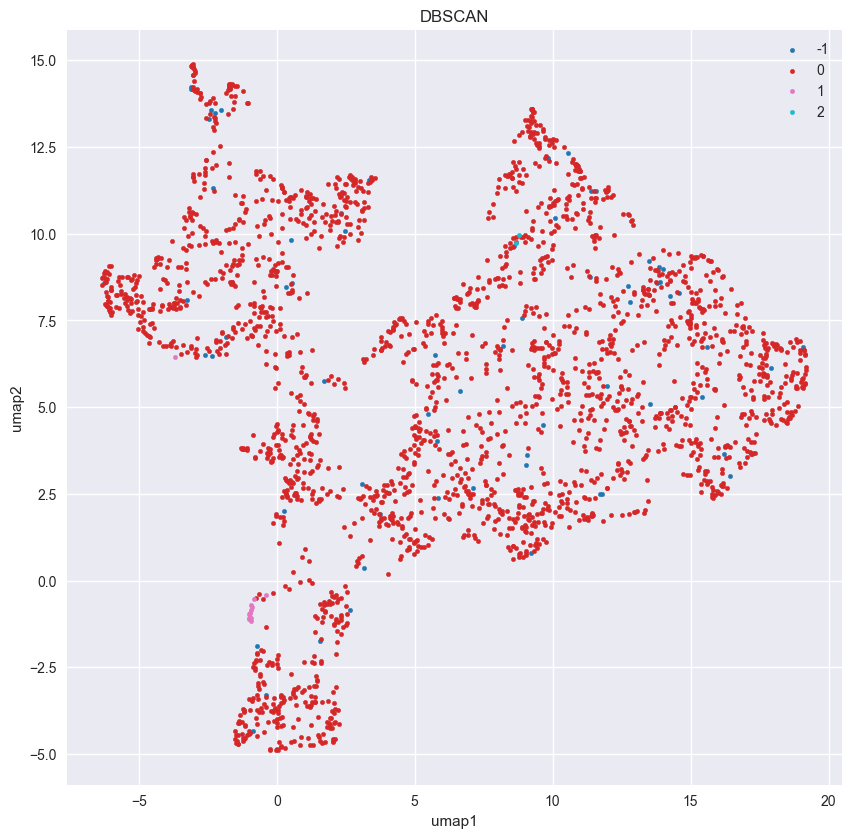

In [60]:
clusters_fig = plot_embeddings(
                embeddings_umap,
                x_label="umap1",
                y_label="umap2",
                title="DBSCAN",
                labels=clusters,
                size=10,
                figsize=(10,10),
                cmap=plt.cm.tab10,
                legend=True,
            )
clusters_fig

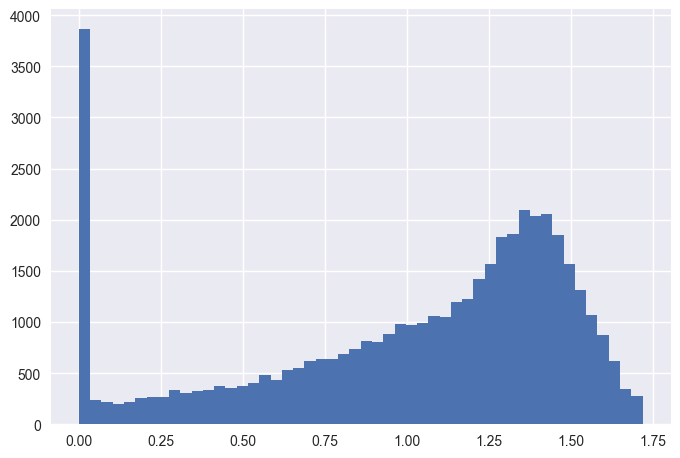

In [38]:
_ = plt.hist(dist_graph.data, bins=50)

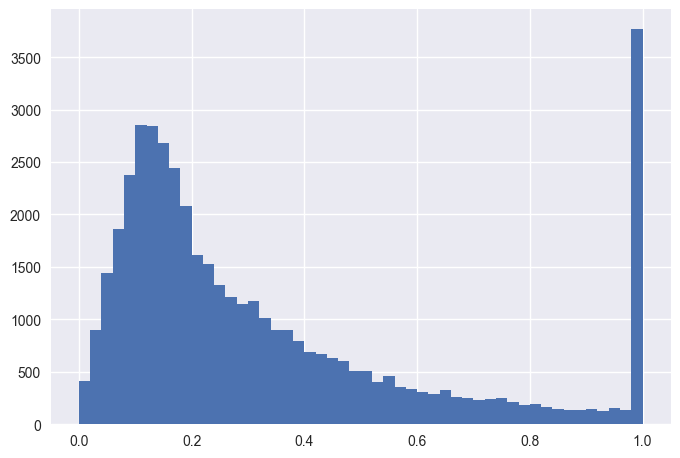

In [39]:
_ = plt.hist(umap_graph.data, bins=50)

In [ ]:
sources_s, targets_s = umap_graph.nonzero()


distance =  scipy.sparse.coo_matrix((weights_e, (sources_e, targets_e)), shape=a_nn.shape)

In [ ]:
distances = numpy.exp(-umap_graph)

In [18]:
umap_graph[0].data

array([0.16976678, 0.16992868, 0.9908673 , 0.16567463, 0.12475271,
       0.10893857, 0.43478936, 0.16967313, 0.28849345, 1.        ,
       0.1302837 , 0.11207185, 0.12580977, 0.17106268], dtype=float32)

(array([ 414.,  882., 1462., 1866., 2394., 2848., 2842., 2664., 2442.,
        2062., 1646., 1510., 1326., 1224., 1150., 1176., 1008.,  900.,
         888.,  796.,  686.,  674.,  638.,  592.,  518.,  506.,  404.,
         452.,  360.,  334.,  318.,  280.,  332.,  264.,  252.,  224.,
         242.,  248.,  220.,  182.,  188.,  170.,  152.,  136.,  138.,
         144.,  134.,  148.,  138., 3770.]),
 array([1.73048818e-06, 2.00016964e-02, 4.00016606e-02, 6.00016266e-02,
        8.00015926e-02, 1.00001559e-01, 1.20001525e-01, 1.40001491e-01,
        1.60001457e-01, 1.80001423e-01, 2.00001389e-01, 2.20001355e-01,
        2.40001321e-01, 2.60001272e-01, 2.80001253e-01, 3.00001204e-01,
        3.20001185e-01, 3.40001136e-01, 3.60001117e-01, 3.80001068e-01,
        4.00001049e-01, 4.20001000e-01, 4.40000981e-01, 4.60000932e-01,
        4.80000913e-01, 5.00000894e-01, 5.20000815e-01, 5.40000796e-01,
        5.60000777e-01, 5.80000699e-01, 6.00000679e-01, 6.20000660e-01,
        6.40000641e-01, 

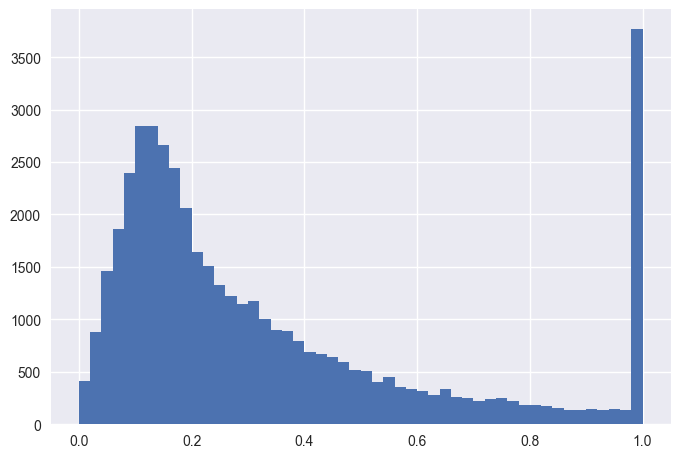

In [19]:
plt.hist(umap_graph.data.flatten(), bins=50)

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/sklearn/neighbors/_base.py:175: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 2400.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <a list of 20 Patch objects>)

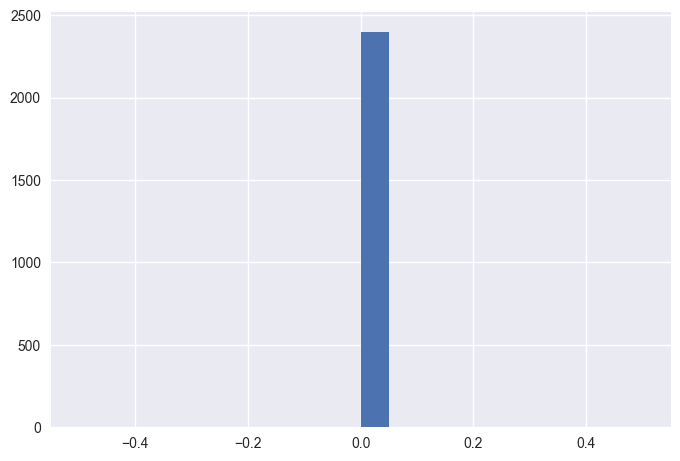

In [ ]:
clustering

In [ ]:
umap_graph

# Logger

In [ ]:
env_vars = !cat ~/.bash_profile | grep NEPTUNE_API_TOKEN 
NEPTUNE_API_TOKEN = str(env_vars[0].split('\"')[1])

In [ ]:
import neptune.new as neptune
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

exp: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_API_TOKEN,
                                    mode="async",
                                    tags=["clustering"])

In [ ]:
partitions = [leidenalg.CPMVertexPartition, leidenalg.RBConfigurationVertexPartition]
normalizations = [True, False]
resolution_parameters = [0.1, 1.0, 10.0]

for p_type in partitions:
    for norm in normalizations:
        for r in resolution_parameters:
            graph = make_graph(umap_graph, normalized=norm)
            clusters = find_partition(graph, partition_type = p_type, resolution_parameter = r)

            clusters_fig = plot_embeddings(
                embeddings_umap,
                x_label="umap1",
                y_label="umap2",
                title=str(p_type)+"_"+str(norm)+"_"+str(r),
                labels=clusters,
                size=10,
                figsize=(10,10),
                cmap=plt.cm.tab10,
                legend=False,
            )
            exp["clusters"].log(neptune.types.File.as_image(clusters_fig))
        

In [ ]:
exp.stop()

## Compare anndata

In [61]:
import scanpy as sc
import pandas as pd

tmp_dict = {
    "f_names" : f_names,
    "morans" : morans,
}

df = pd.DataFrame(tmp_dict)

adata = sc.AnnData(X=features, obs=df)
adata.obsm['X_raw'] = features

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ValueError: Observations annot. `obs` must have number of rows of `X` (2401), but has 2402 rows.

In [62]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=200, use_rep='X_raw', method='umap', metric='euclidean')

NameError: name 'adata' is not defined

In [ ]:
adata

In [ ]:
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden'])

### Can I predict moran?

In [ ]:
x_all = bbone_embeddings
y_all = morans_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=stratify_by,
    test_size=0.2,
    random_state=1)

mlp_regression = MLPRegressor(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)
mlp_regression.fit(x_train, y_train)

r2_test = mlp_regression.score(x_test, y_test)
r2_train = mlp_regression.score(x_train, y_train)

y_test_predicted = mlp_regression.predict(x_test)
y_train_predicted = mlp_regression.predict(x_train)


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
axs[0].scatter(y_train, y_train_predicted)
axs[0].set_ylabel("predicted")
axs[0].set_xlabel("actual")

axs[1].set_title("test dataset")
axs[1].scatter(y_test, y_test_predicted)
axs[1].set_ylabel("predicted")
axs[1].set_xlabel("actual")

axs[2].set_title("mlp loss")
axs[2].plot(mlp.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict moran with good_accuracy", r2_train, r2_test)

### Can I predict the tissue labels?

In [ ]:


x_all = bbone_embeddings
y_all = fnames_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=fnames_all,
    test_size=0.2,
    random_state=1)

mlp_classification = MLPClassifier(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)

mlp_classification.fit(x_train, y_train)

mean_accuracy_test = mlp_classification.score(x_test, y_test)
mean_accuracy_train = mlp_classification.score(x_train, y_train)

y_test_predicted = mlp_classification.predict(x_test)
y_train_predicted = mlp_classification.predict(x_train)

cm_train = confusion_matrix(y_train, y_train_predicted, labels=mlp_classification.classes_)
cm_test = confusion_matrix(y_test, y_test_predicted, labels=mlp_classification.classes_)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                       display_labels=mlp_classification.classes_)
cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=mlp_classification.classes_)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
cm_train_disp.plot(ax=axs[0])

axs[1].set_title("test dataset")
cm_test_disp.plot(ax=axs[1])

axs[2].set_title("mlp loss")
axs[2].plot(mlp_classification.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict tissue with excellent accuracy", mean_accuracy_train, mean_accuracy_test)

## Plot

In [ ]:
file_embeddings = "./output_prediction_random-413.pt"

output_prediction_tiling = torch.load(file_embeddings, map_location=torch.device('cpu'))
print("output_prediction_tiling.keys() -->", output_prediction_random.keys())

bbone_embeddings = output_prediction_tiling["features_bbone_ref_trsfm"]
head_embeddings = output_prediction_tiling["features_head_ref_trsfm"]

metadatas = output_prediction_tiling["metadata"]

morans_all = numpy.array([metadata.moran for metadata in metadatas])
fnames_all = numpy.array([metadata.f_name for metadata in metadatas])

## Plot BackBone embeddings

In [ ]:
bbone_embeddings_pca = get_pca(bbone_embeddings)

bbone_embeddings_umap, distances_bbone_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=15, 
    metric='contrastive')

bbone_umap_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_umap_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
bbone_umap_fig1.savefig("./random_umap_tissue.png")
bbone_umap_fig2.savefig("./random_umap_moran.png")

In [ ]:
paths = save_to_local_path([bbone_umap_fig1, bbone_umap_fig2, bbone_pca_fig1, bbone_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

## Plot Head embeddings

In [ ]:
head_embeddings = output_prediction_random["features_head_ref_trsfm"]

head_embeddings_pca = get_pca(head_embeddings)

head_embeddings_umap, distances_head_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=50, 
    metric='contrastive')

head_umap_fig1 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_umap_fig2 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig1 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig2 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
paths = save_to_local_path([head_umap_fig1, head_umap_fig2, head_pca_fig1, head_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

# Unsupervised clustering of the Head embeddings

In [ ]:
distances_nn = distances_head_nn
embeddings_umap = head_embeddings_umap

graph_umap = make_graph(distances_nn=distances_head_nn,
                        n_neighbors=50,
                        metric='contrastive'
                       )

partition_umap = compute_partition(graph_umap, resolution_parameter=0.2)
 
cluster_plot = plot_embeddings(
    embeddings=embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="UMAP",
    colors=None,
    labels=partition_umap.membership,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

display(cluster_plot)

# FROM HERE. MAKE A CLASSIFIER WHICH PREDICTS THE CLUSTERS AND THEN WORK ON TILING. SWITCH IN NEW EMBEDDINGS

### Common import and set random seed

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200
torch.manual_seed(config['simulation']['RANDOM_SEED'])
np.random.seed(config['simulation']['RANDOM_SEED'])

### Read in all the csv file

In [ ]:
#data_folder = "/home/jupyter/data/slide-seq/original_data/"
data_folder = "../slide-seq-data"


df_wt1 = pd.read_csv(os.path.join(data_folder, "wt_1.csv"))
df_wt2 = pd.read_csv(os.path.join(data_folder, "wt_2.csv"))
df_wt3 = pd.read_csv(os.path.join(data_folder, "wt_3.csv"))
df_dis1 = pd.read_csv(os.path.join(data_folder, "sick_1.csv"))
df_dis2 = pd.read_csv(os.path.join(data_folder, "sick_2.csv"))
df_dis3 = pd.read_csv(os.path.join(data_folder, "sick_3.csv"))

## Cluster Embeddings

In [ ]:
from tissue_purifier.model_utils import TrainedEmbedding

model_folder = "../trained_model"
model = tp.model_utils.helpers.define_model(
    backbone_type=config["model_settings"]["BACKBONE_TYPE"],
    number_of_channels=config["model_settings"]["INPUT_CHANNELS"],
    num_of_filters=config["model_settings"]["BACKBONE_NUM_FTRS"],
    projection_out_dim=config["model_settings"]["PROJECTION_OUT_DIM"],
)
model.backbone.load_state_dict(torch.load(f"./model.pth")["resnet18_parameters"])
# model.load_state_dict(torch.load(f"{model_folder}/simclr_model_11.pt"))
model = model.cuda()
encoder = TrainedEmbedding(model)

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca_aglomerative = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=15)), 
        ("cluster", AgglomerativeClustering(n_clusters=2))
    ]
)


In [ ]:
%%capture
mask_dis2 = tp.evaluation_utils.create_mask_for_sample(
    df_dis2, encoder, pca_aglomerative, config, proba=True, n_crops=1000
)

In [ ]:
df_dis2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis2, mask_dis2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis2["condition"] = df_dis2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)

In [ ]:
tp.plot_utils.disease_mask(df_dis2, "condition", figsize=(8, 4), title="DIS 2 Clustered Mask")

In [ ]:
%%capture
mask_wt2 = tp.evaluation_utils.create_mask_for_sample(df_wt2, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt2, mask_wt2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt2["condition"] = df_wt2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)
tp.plot_utils.disease_mask(df_wt2, "condition", figsize=(8, 3), title="WT 2 Clustered Mask")

In [ ]:
%%capture
mask_dis1 = tp.evaluation_utils.create_mask_for_sample(df_dis1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_dis1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis1, mask_dis1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis1["condition"] = df_dis1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_dis1, "condition", figsize=(8, 4), title="DIS 1 Clustered Mask")

In [ ]:
%%capture
mask_wt1 = tp.evaluation_utils.create_mask_for_sample(df_wt1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt1, mask_wt1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt1["condition"] = df_wt1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_wt1, "condition", figsize=(8, 4), title="WT 1 Clustered Mask")

## Moran's I Score Evaluation

In [ ]:
%%capture
moran_averaged = tp.evaluation_utils.moran_score_averaged(
    [df_wt1, df_wt2, df_dis1, df_dis2],
    ["WT1", "WT2", "DIS1", "DIS2"]
)

In [ ]:
moran_averaged.columns = ["total", "COND1", "COND2"]
moran_averaged